In [1]:
from __future__ import print_function
import torch
from torchvision import datasets, transforms
import numpy as np
from WeakLearners import WongNeuralNetCIFAR10
import matplotlib.pyplot as plt

In [2]:
!pip install pytorch_memlab

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from Boosting import Ensemble, runBoosting
from AdversarialAttacks import attack_fgsm, attack_pgd
from pytorch_memlab import LineProfiler

In [4]:
import utils

In [5]:
cuda = torch.device('cuda:0')

In [6]:
%load_ext autoreload
%autoreload 2

## CIFAR10 Boosting (Adversarial)

In [7]:
# maxSamples_vals = [10000, 50000, 100000, 200000, 500000]
# maxSamples_vals = [50000]
maxSamples_vals = [10000]

In [8]:
num_wl = 1 # maybe around 100? #later: maybe change this to an array?
num_epochs = 1

In [9]:
ensembles = []
epsilons = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
attack eps ens [0.0, 0.01, 0.02, 0.03, 0.05, 0.1]
----------------------------------------------------------------------------------------------------
Training weak learner 0
adv_train: True
Epoch 0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/cifar.py:118: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img, target = self.data[index], self.targets[index]


Progress: 3200,  val accuracy: 0.2188
Progress: 6400,  val accuracy: 0.3750
Progress: 9600,  val accuracy: 0.5312


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Training accuracy of weak learner:  0.25232
Alpha:  0.17088872530046248
t:  0 memory allocated: 136569344
Progress: 0,  val accuracy: 0.2812
Finished in 149.238866  s


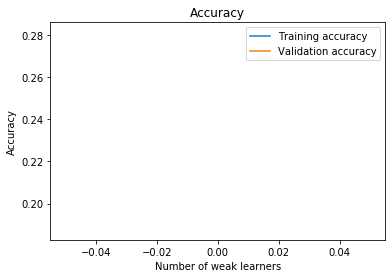

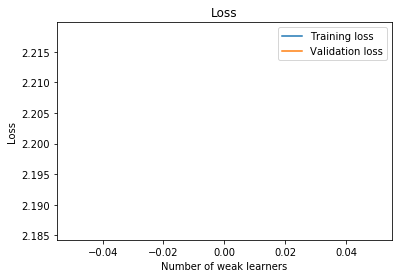

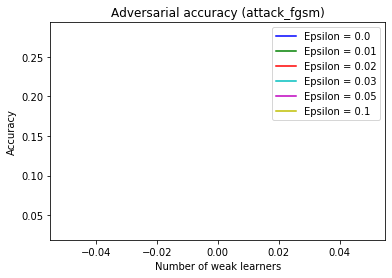

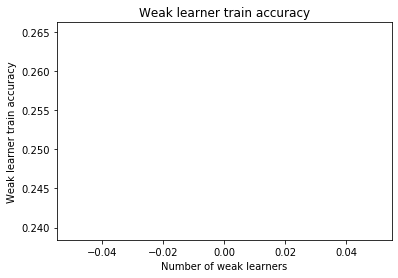

active_bytes,reserved_bytes,line,code
all,all,,
peak,peak,,
2.00K,2.00M,316,"def runBoosting(numWL, maxSamples, dataset=datasets.CIFAR10, weakLearnerType=WongNeuralNetCIFAR10, adv_train=False, val_attacks=[],"
,,317,"attack_eps_nn=[], attack_eps_ensemble=[], train_eps_nn=0.3, batch_size=200):"
,,318,
2.00K,2.00M,319,"train_dataset = dataset('./data', train=True, download=True, transform=transforms.Compose(["
2.00K,2.00M,320,"transforms.ToTensor(),"
,,321,]))
,,322,
2.00K,2.00M,323,"test_dataset = dataset('./data', train=False, download=True, transform=transforms.Compose(["


In [10]:
from Boosting import SchapireWongMulticlassBoosting
from AdversarialAttacks import attack_fgsm
# Ensemble.record_accuracies, Ensemble.calc_accuracies, attack_fgsm, Ensemble.schapireContinuousPredict
with LineProfiler(runBoosting, SchapireWongMulticlassBoosting, WongNeuralNetCIFAR10.fit) as prof:
    for i in range(len(maxSamples_vals)):
        maxSamples = maxSamples_vals[i]
        ensemble = runBoosting(num_wl, maxSamples, dataset=datasets.CIFAR10, weakLearnerType = WongNeuralNetCIFAR10, val_attacks = [attack_fgsm], 
                                   attack_eps_nn=epsilons, attack_eps_ensemble=epsilons, train_eps_nn=8, adv_train=True, batch_size=32)
        ensembles.append(ensemble)
        path_head = 'results/plots/cifar10/'
        acc_file = path_head + f'acc_maxSamples_{maxSamples}.png'
        adv_acc_file = path_head + f'adv_acc_maxSamples_{maxSamples}.png'
        loss_file = path_head + f'loss_maxSamples_{maxSamples}.png'
        wl_train_acc_file = path_head + f'wl_train_acc_maxSamples_{maxSamples}.png'
        ensemble.plot_accuracies(acc_file)
        ensemble.plot_loss(loss_file)
        ensemble.plot_adversarial_accuracies(adv_acc_file)
        ensemble.plot_wl_train_acc(wl_train_acc_file)
prof.display()

In [ ]:
# for maxSamples in maxSamples_vals:
#         ensemble = runBoosting(num_wl, maxSamples, dataset=datasets.CIFAR10, weakLearnerType = WongNeuralNetCIFAR10, val_attacks = [attack_fgsm], 
#                                attack_eps_nn=epsilons, attack_eps_ensemble=epsilons, train_eps_nn=8, adv_train=True)
#         ensembles.append(ensemble)

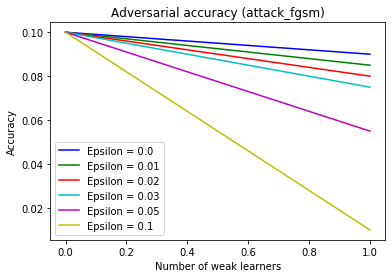

In [12]:
ensembles[0].plot_adversarial_accuracies()

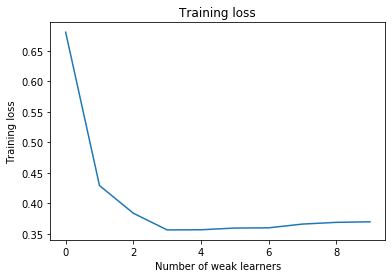

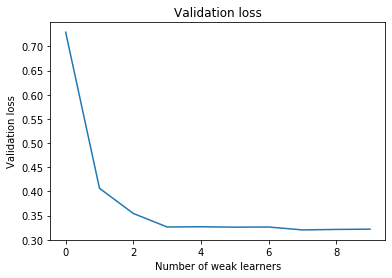

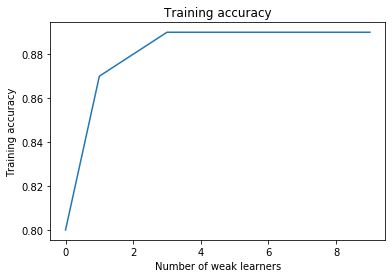

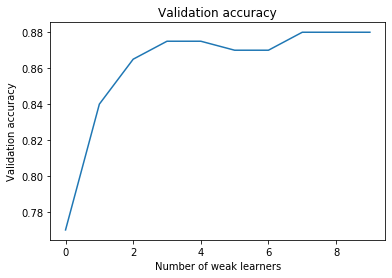

In [11]:
ensembles[0].plot_train_loss()
ensembles[0].plot_val_loss()
ensembles[0].plot_train_accuracies()
ensembles[0].plot_val_accuracies()

In [10]:
ensembles[0].attack_eps

[]